In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

2024-08-29 11:34:10.104354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 11:34:10.218343: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [4]:
import os
import cv2
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터셋의 루트 디렉토리 및 라벨 맵핑
dataset_directory = 'eardrumDs'
label_map = {'Normal': 0, 'Aom': 1, 'Chornic': 2, 'Earwax': 3}

# 데이터셋 로드 및 이미지 경로와 라벨 리스트 생성
image_paths = []
image_labels = []

exclude_folders = {'OtitExterna', 'tympanoskleros', 'Earventulation', 'Foreign', 'PseduoMembran'}
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders or label_folder == '.DS_Store':
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            img = cv2.imread(full_path)
            if img is None:  # 이미지 로드 실패 시 예외 처리
                print(f"Warning: Failed to load image {full_path}")
                continue
            image_labels.append(label_map[label_folder])
            image_paths.append(full_path)

# Train-test split (8:2 비율)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, image_labels, test_size=0.2, random_state=1881)

# PyTorch로 one-hot 인코딩
num_classes = len(label_map)
train_labels_one_hot = torch.nn.functional.one_hot(torch.tensor(train_labels), num_classes=num_classes).float()
test_labels_one_hot = torch.nn.functional.one_hot(torch.tensor(test_labels), num_classes=num_classes).float()

# 레이블 스무딩 함수
def smooth_labels(labels, smoothing_factor=0.1):
    num_classes = labels.shape[1]
    return labels * (1 - smoothing_factor) + (smoothing_factor / num_classes)

train_labels_smoothed = smooth_labels(train_labels_one_hot, smoothing_factor=0.1)
test_labels_smoothed = smooth_labels(test_labels_one_hot, smoothing_factor=0.1)

print(f"Training set size: {len(train_paths)}")
print(f"Test set size: {len(test_paths)}")

Training set size: 684
Test set size: 172


In [5]:
import torch

# 일부 샘플 레이블을 출력하는 함수
def print_sample_labels(labels, num_samples=20):
    # 주어진 레이블에서 num_samples만큼 랜덤으로 선택
    indices = torch.randint(0, len(labels), (num_samples,))
    
    for idx in indices:
        print(f"Sample index: {idx}, Label: {labels[idx].numpy()}")

# 샘플 레이블 확인 (train_labels_smoothed를 사용)
print_sample_labels(train_labels_smoothed, num_samples=20)

Sample index: 214, Label: [0.025      0.025      0.025      0.92499995]
Sample index: 559, Label: [0.025      0.92499995 0.025      0.025     ]
Sample index: 255, Label: [0.025      0.025      0.025      0.92499995]
Sample index: 620, Label: [0.92499995 0.025      0.025      0.025     ]
Sample index: 215, Label: [0.92499995 0.025      0.025      0.025     ]
Sample index: 519, Label: [0.025      0.92499995 0.025      0.025     ]
Sample index: 631, Label: [0.92499995 0.025      0.025      0.025     ]
Sample index: 464, Label: [0.92499995 0.025      0.025      0.025     ]
Sample index: 342, Label: [0.025      0.92499995 0.025      0.025     ]
Sample index: 347, Label: [0.025      0.025      0.025      0.92499995]
Sample index: 322, Label: [0.92499995 0.025      0.025      0.025     ]
Sample index: 164, Label: [0.92499995 0.025      0.025      0.025     ]
Sample index: 458, Label: [0.025      0.025      0.025      0.92499995]
Sample index: 436, Label: [0.92499995 0.025      0.025      0.02

In [6]:
from tensorflow.keras.utils import Sequence
import albumentations as at
from tensorflow.keras.utils import to_categorical

SEED = 1881

# 데이터 제너레이터 클래스
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, seed, augment=False, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.SEED = seed
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_paths = [self.image_paths[k] for k in batch_indexes]
        batch_labels = [self.labels[k] for k in batch_indexes]
        X, y = self.__data_generation(batch_image_paths, batch_labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.seed(self.SEED)
            np.random.shuffle(self.indexes)

    def get_shuffled_data(self):
        # 셔플된 이미지 경로와 레이블을 반환
        train_img_paths, train_labels = train_paths, train_labels_smoothed

        # 이미지와 레이블을 동일한 순서로 셔플링
        combined = list(zip(train_img_paths, train_labels))
        np.random.seed(self.SEED)
        np.random.shuffle(combined)
        train_img_paths[:], train_labels[:] = zip(*combined)

        test_img_paths, test_labels = test_paths, test_labels_smoothed
        combined_test = list(zip(test_img_paths, test_labels))
        np.random.seed(self.SEED)
        np.random.shuffle(combined_test)
        test_img_paths[:], test_labels[:] = zip(*combined_test)

        return train_img_paths, train_labels, test_img_paths, test_labels

    def split_train_test(self, get):  # get=={"train", "test"}
        train_img_paths, train_labels, test_img_paths, test_labels = self.get_shuffled_data()

        if get == 'train':
            return train_img_paths, train_labels
        elif get == 'test':
            return test_img_paths, test_labels

    def __data_generation(self, batch_image_paths, batch_labels):
        X = np.empty((self.batch_size, 224, 224, 3), dtype=np.float32)
        y = np.empty((self.batch_size, len(self.labels[0])), dtype=np.float32)  # One-hot or smoothed labels

        if self.augment:
            data_gen_args = at.Compose([
                at.HorizontalFlip(p=0.5),
                at.VerticalFlip(p=0.5),
                at.RandomBrightnessContrast(p=0.3),
                at.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.05, rotate_limit=20, p=0.5)
            ])

        for i, (img_path, label) in enumerate(zip(batch_image_paths, batch_labels)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))

            if self.augment:
                img = data_gen_args(image=img)['image']

            X[i,] = img.astype(np.float32) / 255.0
            y[i] = label  # 이미 one-hot 또는 smoothed된 label이므로 변환 불필요

        return X, y

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


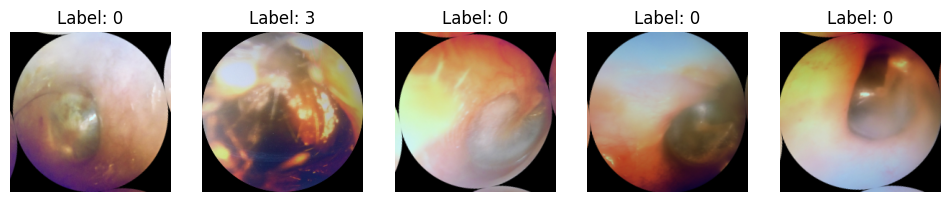

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋 생성
train_generator = DataGenerator(x_train, y_train, batch_size=24, augment=True, shuffle=True)
val_generator = DataGenerator(x_test, y_test, batch_size=24, augment=False, shuffle=False)

# 데이터 증강 시각화 함수
def visualize_augmentations(generator, num_images=5):
    # 배치에서 샘플 추출
    X, y = next(iter(generator))
    
    # 증강된 이미지 시각화
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i])
        plt.title(f"Label: {np.argmax(y[i])}")
        plt.axis("off")
    plt.show()

# 데이터 증강 시각화 (train 데이터에서)
visualize_augmentations(train_generator)

In [9]:
def check_class_distribution(generator):
    total_batches = len(generator)  # 전체 배치 수
    total_samples = total_batches * generator.batch_size  # 전체 샘플 수 추정

    print(f"Total Samples: {total_samples}")
    print(f"Batch Size: {generator.batch_size}")
    print(f"Total Batches: {total_batches}")

# 클래스별 데이터 분포 확인 (train 데이터)
check_class_distribution(train_generator)

# 클래스별 데이터 분포 확인 (validation 데이터)
check_class_distribution(val_generator)

Total Samples: 672
Batch Size: 24
Total Batches: 28
Total Samples: 168
Batch Size: 24
Total Batches: 7


In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs_range=None):
    
    if epochs_range is None:
        epochs_range = range(len(history.history['accuracy']))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(16, 8))
    
    # Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [15]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_and_visualize_model(model, val_generator):
    # 모델 예측
    y_pred = []
    y_true = []
    for images, labels in val_generator:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))  # 수정된 부분

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Classification Report 출력
    print(classification_report(y_true, y_pred))

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

class SGDRScheduler(Callback):
    def __init__(self,
                 min_lr=1e-6,
                 max_lr=1e-3,
                 steps_per_epoch=5,
                 lr_decay=0.9,
                 cycle_length=10,
                 mult_factor=2):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the maximum value at the start of training.'''
        if logs is None:
            logs = {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        if logs is None:
            logs = {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs=None):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)


In [17]:
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, UpSampling2D, Dropout, Dense, Reshape, Concatenate, Conv2D, Activation, multiply, Permute, Lambda, Add, BatchNormalization, LeakyReLU, add, Input
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():
def create_model():
    
    # Convolutional Block 정의
    def conv_block(x, filters):
        x = Conv2D(filters, (3, 3), activation = None, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x
    
    def cbam_block(cbam_feature, ratio=8):
        cbam_feature = channel_attention(cbam_feature, ratio)
        cbam_feature = spatial_attention(cbam_feature)
        return cbam_feature

    def channel_attention(input_feature, ratio=8):
        channel_axis = 1 if K.image_data_format() == "channels_first" else -1
        channel = input_feature.shape[channel_axis]
        
        shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')
        shared_layer_two = Dense(channel,kernel_initializer='he_normal',use_bias=True,bias_initializer='zeros')
        
        avg_pool = GlobalAveragePooling2D()(input_feature)
        avg_pool = Reshape((1, 1, channel))(avg_pool)
        #assert avg_pool.shape[1:] == (1,1,channel)
        avg_pool = shared_layer_one(avg_pool)
        #assert avg_pool.shape[1:] == (1,1,channel//ratio)
        avg_pool = shared_layer_two(avg_pool)
        #assert avg_pool.shape[1:] == (1,1,channel)
        
        max_pool = GlobalMaxPooling2D()(input_feature)
        max_pool = Reshape((1, 1, channel))(max_pool)
        #assert max_pool.shape[1:] == (1,1,channel)
        max_pool = shared_layer_one(max_pool)
        #assert max_pool.shape[1:] == (1,1,channel//ratio)
        max_pool = shared_layer_two(max_pool)
        #assert max_pool.shape[1:] == (1,1,channel)
        
        cbam_feature = Add()([avg_pool, max_pool])
        cbam_feature = Activation('sigmoid')(cbam_feature)

        if K.image_data_format() == "channels_first":
            cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
        return multiply([input_feature, cbam_feature])

    def spatial_attention(input_feature):
        kernel_size = 7
        
        if K.image_data_format() == "channels_first":
            cbam_feature = Permute((2, 3, 1))(input_feature)
        else:
            cbam_feature = input_feature
        
        avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
        #assert avg_pool.shape[-1] == 1
        max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
        #assert max_pool.shape[-1] == 1
        concat = Concatenate(axis=3)([avg_pool, max_pool])
        #assert concat.shape[-1] == 2
        cbam_feature = Conv2D(filters=1,kernel_size=kernel_size,strides=1,padding='same',activation='sigmoid',kernel_initializer='he_normal',use_bias=False)(concat)
        #assert cbam_feature.shape[-1] == 1
        
        if K.image_data_format() == "channels_first":
            cbam_feature = Permute((3, 1, 2))(cbam_feature)
            
        return multiply([input_feature, cbam_feature])
    
    def residual_block(x, filters, _strides=(1, 1), _project_shortcut=False):
        shortcut = x

        # 첫 번째 Conv2D 레이어
        x = Conv2D(filters, kernel_size=(3, 3), strides=_strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        # 두 번째 Conv2D 레이어
        x = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)

        # 조건에 따라 projection shortcut을 사용하여 차원 맞춤
        if _project_shortcut or _strides != (1, 1):
            shortcut = Conv2D(filters, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)

        # Residual connection
        x = add([x, shortcut])
        x = LeakyReLU()(x)

        return x
    
    def stage1(input_tensor):
        x = conv_block(input_tensor, 32)
        x = conv_block(x, 32)
        x1 = MaxPooling2D((2, 2))(x)
        return x1
    
    def stage2(input_tensor):
        x = conv_block(input_tensor, 64)
        x = cbam_block(x)
        x = residual_block(x, 64)
        x2 = MaxPooling2D((2, 2))(x)
        return x2
    
    def stage3(input_tensor):
        x = conv_block(input_tensor, 128)
        x = cbam_block(x)
        x = residual_block(x, 128)
        x3 = MaxPooling2D((2, 2))(x)
        return x3
    
    input_tensor = Input(shape=(224, 224, 3))

    stage1_output = stage1(input_tensor)
    stage2_output = stage2(stage1_output)
    stage3_output = stage3(stage2_output)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(stage1_output)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(stage2_output)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(stage3_output)
    
    concatenated = Concatenate()([ginp1, ginp2, ginp3])
    x = GlobalAveragePooling2D()(concatenated)
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    return model

In [18]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 224, 224, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 224, 224, 32  128        ['conv2d_10[0][0]']              
 ormalization)                  )                                                           

In [19]:
from tensorflow.keras import mixed_precision

# Mixed Precision 비활성화
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

Fold 1
Epoch 1/100


2024-08-29 11:34:57.057334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-08-29 11:34:57.620713: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-29 11:34:57.625027: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-08-29 11:34:58.356851: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55b09f143630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-29 11:34:58.356904: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2024-08-29 11:34:58.356918: I te

22/22 - 16s - loss: 1.2866 - accuracy: 0.5152 - val_loss: 1.3142 - val_accuracy: 0.5333 - 16s/epoch - 724ms/step
Epoch 2/100
22/22 - 6s - loss: 1.0661 - accuracy: 0.6629 - val_loss: 1.2397 - val_accuracy: 0.5417 - 6s/epoch - 266ms/step
Epoch 3/100
22/22 - 5s - loss: 1.0304 - accuracy: 0.6629 - val_loss: 1.2115 - val_accuracy: 0.5500 - 5s/epoch - 244ms/step
Epoch 4/100
22/22 - 5s - loss: 0.9907 - accuracy: 0.6970 - val_loss: 1.2581 - val_accuracy: 0.5167 - 5s/epoch - 229ms/step
Epoch 5/100
22/22 - 5s - loss: 0.9333 - accuracy: 0.7064 - val_loss: 1.2710 - val_accuracy: 0.5000 - 5s/epoch - 225ms/step
Epoch 6/100
22/22 - 5s - loss: 0.9254 - accuracy: 0.7159 - val_loss: 1.2992 - val_accuracy: 0.5083 - 5s/epoch - 229ms/step
Epoch 7/100
22/22 - 5s - loss: 0.9310 - accuracy: 0.7292 - val_loss: 1.2590 - val_accuracy: 0.5500 - 5s/epoch - 228ms/step
Epoch 8/100
22/22 - 5s - loss: 0.8538 - accuracy: 0.7557 - val_loss: 1.3970 - val_accuracy: 0.5333 - 5s/epoch - 228ms/step
Epoch 9/100
22/22 - 5s - l

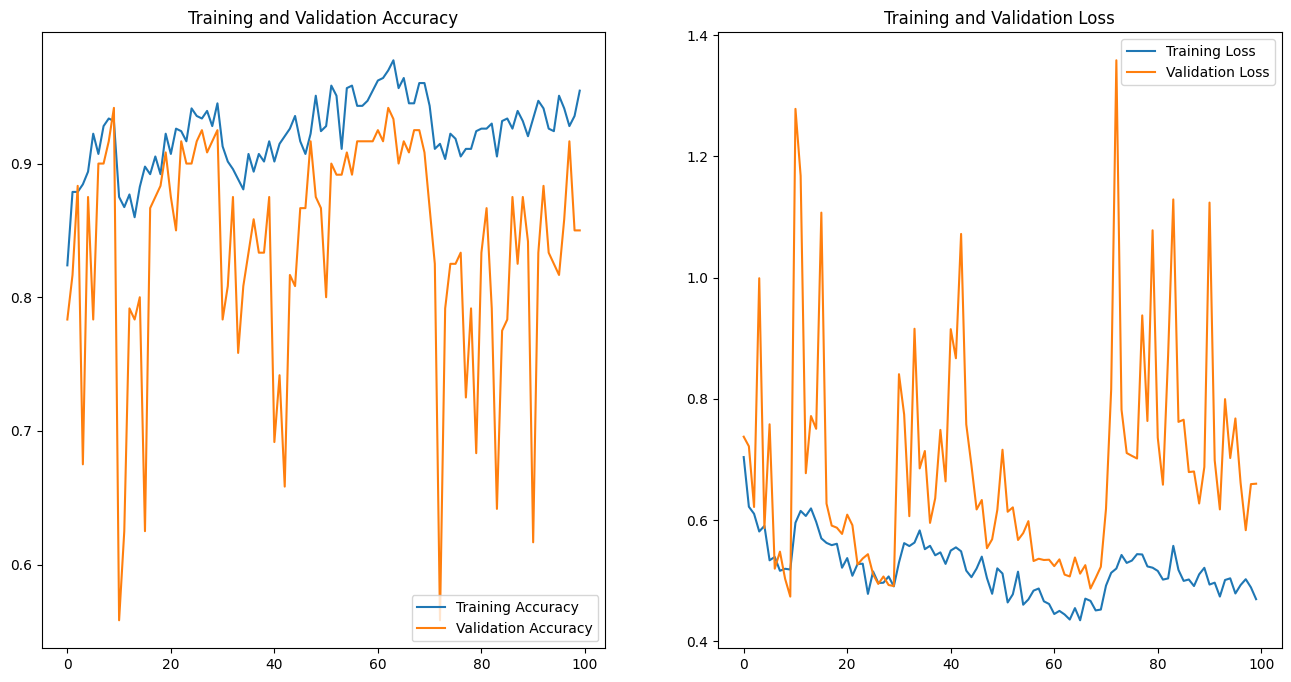

1/1 [==============================] - 0s 57ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        80
           1       0.85      0.73      0.79        15
           2       0.86      0.75      0.80         8
           3       0.89      0.94      0.91        17

    accuracy                           0.93       120
   macro avg       0.89      0.85      0.87       120
weighted avg       0.92      0.93      0.92       120



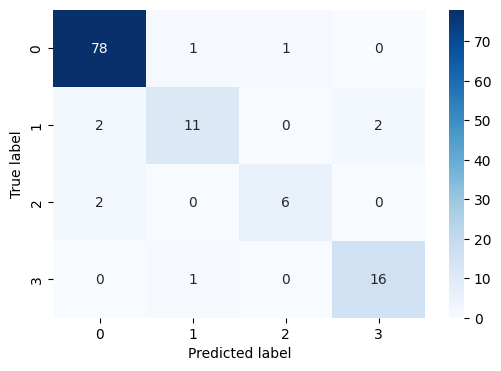

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from math import ceil

BATCH_SIZE = 24
EPOCHS = 100
kf = KFold(n_splits=5, shuffle=True, random_state=1881)
all_fold_accuracies = []

image_paths = train_paths 
labels = train_labels_smoothed

for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths)):
    print(f"Fold {fold + 1}")

    tg = DataGenerator(
        [image_paths[i] for i in train_idx], 
        [labels[i] for i in train_idx], 
        batch_size=BATCH_SIZE, 
        seed=SEED, 
        augment=True
    )
    
    vg = DataGenerator(
        [image_paths[i] for i in val_idx], 
        [labels[i] for i in val_idx], 
        batch_size=BATCH_SIZE, 
        seed=SEED, 
        augment=False
    )

    # 학습률 스케줄러 설정
    lr_scheduler = SGDRScheduler(min_lr=1e-6, max_lr=1e-3, steps_per_epoch=ceil(len(train_idx) / BATCH_SIZE), lr_decay=0.9, cycle_length=10, mult_factor=2.)
    
    # 모델 컴파일
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

    # 체크포인트 콜백 설정
    model_ckpt = f"model_fold_{fold + 1}.h5"
    model_checkpoint_callback = ModelCheckpoint(
        filepath=model_ckpt,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    )

    # TensorBoard 콜백 설정
    tensorboard_callback = TensorBoard(log_dir=f'./logs/fold_{fold + 1}', update_freq='batch')

    # 모델 학습
    history = model.fit(
        tg,
        steps_per_epoch=len(train_idx) // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=2,
        validation_data=vg,
        validation_steps=len(val_idx) // BATCH_SIZE,
        callbacks=[lr_scheduler, model_checkpoint_callback, tensorboard_callback]
    )

    print(f"Fold {fold + 1} completed.")
    all_fold_accuracies.append(max(history.history['val_accuracy']))

# 최종 결과 출력
print(f"Cross-validated Accuracy: {np.mean(all_fold_accuracies):.4f}")

plot_training_history(history)

# Confusion matrix 및 Classification report 출력 (마지막 fold로 테스트)
evaluate_and_visualize_model(model, vg)

100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


Evaluating model_fold_1.h5
Model 1 - Loss: 256912736045752661983046402048.0000, Accuracy: 0.7326
Evaluating model_fold_2.h5
Model 2 - Loss: 972634241289623392477775921152.0000, Accuracy: 0.7442
Evaluating model_fold_3.h5
Model 3 - Loss: 668434730709497208419133685760.0000, Accuracy: 0.7326
Evaluating model_fold_4.h5
Model 4 - Loss: 190434547466985873937702846464.0000, Accuracy: 0.7733
Evaluating model_fold_5.h5
Model 5 - Loss: 382492833425441646685682925568.0000, Accuracy: 0.7442
Accuracy: 0.7384, F1_Score: 0.6279, Precision: 0.6638, Recall: 0.6064

Classification Report:
               precision    recall  f1-score   support

      Normal       0.77      0.84      0.80       106
         Aom       0.67      0.43      0.53        23
        Csom       0.45      0.38      0.42        13
      Earwax       0.77      0.77      0.77        30

    accuracy                           0.74       172
   macro avg       0.66      0.61      0.63       172
weighted avg       0.73      0.74      0

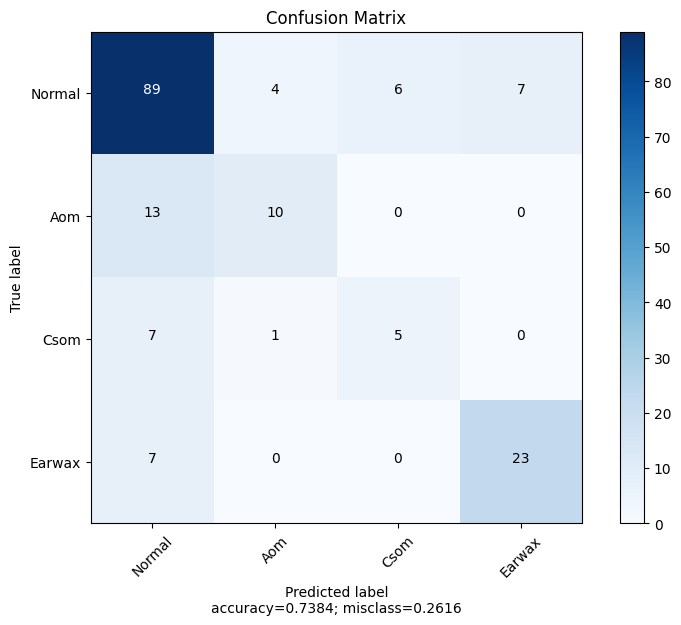

In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # for progress bar
import itertools

SHAPE = (224, 224, 3)
# 테스트 데이터 로딩 함수
def get_test_data():
    test_generator = DataGenerator(
        image_paths=test_paths, 
        labels=test_labels_smoothed, 
        batch_size=BATCH_SIZE, 
        seed=SEED, 
        augment=False,  # Test 데이터에서는 Augmentation이 필요 없음
        shuffle=False   # Test 데이터에서는 순서가 중요하므로 shuffle하지 않음
    )

    x = np.empty((len(test_paths),) + SHAPE, dtype=np.float32)
    y = np.empty((len(test_paths), 4), dtype=np.float32)

    for ix, (images, labels) in tqdm(enumerate(test_generator), total=len(test_generator)):
        x[ix*BATCH_SIZE:(ix+1)*BATCH_SIZE] = images
        y[ix*BATCH_SIZE:(ix+1)*BATCH_SIZE] = labels

    return x, y

# 테스트 데이터 불러오기
x, y = get_test_data()

# 모델 로드 및 평가
models = []
model_files = ['model_fold_1.h5', 'model_fold_2.h5', 'model_fold_3.h5', 'model_fold_4.h5', 'model_fold_5.h5']

for i, model_file in enumerate(model_files):
    model = load_model(model_file)
    print(f"Evaluating {model_file}")
    loss, accuracy = model.evaluate(x, y, verbose=0)
    print(f"Model {i+1} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
    models.append(model)

# 예측 및 평가
y_preds = models[-1].predict(x, verbose=0)
y_preds = np.argmax(y_preds, axis=1)
y_true = np.argmax(y, axis=1)

# 성능 지표 계산 및 출력
results = precision_recall_fscore_support(y_true, y_preds, average='macro')
acc = accuracy_score(y_true, y_preds)

print(f"Accuracy: {acc:.4f}, F1_Score: {results[2]:.4f}, Precision: {results[0]:.4f}, Recall: {results[1]:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_preds, target_names=['Normal', 'Aom', 'Csom', 'Earwax']))

# 혼동 행렬 생성
cnf_matrix = confusion_matrix(y_true, y_preds)

# 혼동 행렬 시각화 함수
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.4f}".format(cm[i, j]) if normalize else "{:,}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\naccuracy={accuracy:.4f}; misclass={misclass:.4f}')
    plt.savefig("confusion_matrix_best.jpg", dpi=150)
    plt.show()

# 혼동 행렬 시각화
plot_confusion_matrix(cm=cnf_matrix, normalize=False, target_names=['Normal', 'Aom', 'Csom', 'Earwax'], title="Confusion Matrix")

In [17]:
from tensorflow.keras.models import load_model

# 모델 아키텍처 정의
model = create_model()  # create_model 함수가 모델의 아키텍처를 반환

# 가중치 로드
model.load_weights('model_fold_5.h5')

# 새로운 이미지 전처리
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# 이미지 예측
new_image_path = 'fig_eardrum/Normal_f/100_0016.png'
processed_image = preprocess_image(new_image_path)
prediction = model.predict(processed_image)

# 예측 결과 확인
class_names = ['Normal', 'Aom', 'Chornic', 'Earwax']
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")

1/1 [==============================] - 1s 638ms/step
Predicted Class: Normal, Confidence: 1.00


In [18]:
new_image_path = 'fig_eardrum/Aom_f/100_0112.png'
processed_image = preprocess_image(new_image_path)
prediction = model.predict(processed_image)

# 예측 결과 확인
class_names = ['Normal', 'Aom', 'Chornic', 'Earwax']
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")

1/1 [==============================] - 0s 78ms/step
Predicted Class: Aom, Confidence: 1.00


In [19]:
new_image_path = 'fig_eardrum/Chornic_f/100_0141.png'
processed_image = preprocess_image(new_image_path)
prediction = model.predict(processed_image)

# 예측 결과 확인
class_names = ['Normal', 'Aom', 'Chornic', 'Earwax']
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")

1/1 [==============================] - 0s 38ms/step
Predicted Class: Chornic, Confidence: 1.00


In [20]:
new_image_path = '100_0330.png'
processed_image = preprocess_image(new_image_path)
prediction = model.predict(processed_image)

# 예측 결과 확인
class_names = ['Normal', 'Aom', 'Chornic', 'Earwax']
predicted_class = np.argmax(prediction, axis=1)[0]
confidence = np.max(prediction)

print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {confidence:.2f}")

1/1 [==============================] - 0s 40ms/step
Predicted Class: Earwax, Confidence: 1.00


7/8 [=========================>....] - ETA: 0s - loss: 0.8769 - accuracy: 0.7976WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 8 batches). You may need to use the repeat() function when building your dataset.


8/8 [==============================] - 2s 143ms/step - loss: 0.8769 - accuracy: 0.7976
Test Loss: 0.8769
Test Accuracy: 0.7976
1/1 [==============================] - 0s 57ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.82      0.92      0.87       106
         Aom       0.71      0.50      0.59        20
     Chornic       0.56      0.42      0.48        12
      Earwax       0.81      0.73      0.77        30

    accuracy                           0.80       168
   macro avg       0.73      0.64      0.68       168
weighted avg       0.79      0.80      0.79       168



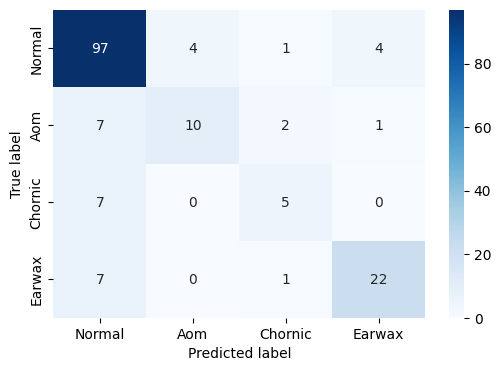

In [46]:
from tensorflow.keras.models import load_model

def evaluate_and_visualize_model(model, val_generator):
    # 모델 예측
    y_pred = []
    y_true = []
    for images, labels in val_generator:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(np.argmax(labels, axis=1))

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Classification Report 출력
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Aom', 'Chornic', 'Earwax']))

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Aom', 'Chornic', 'Earwax'], yticklabels=['Normal', 'Aom', 'Chornic', 'Earwax'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 모델 불러오기 및 컴파일
model = create_model()  # 여기서 create_model은 모델 구조를 정의해야 함
model.load_weights('model_fold_1.h5')

# 모델 재컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

# 데이터 제너레이터 생성 (test data용)
test_generator = DataGenerator(
    image_paths=test_paths, 
    labels=test_labels_smoothed, 
    batch_size=BATCH_SIZE, 
    seed=SEED, 
    augment=False,  # Test 데이터에서는 Augmentation이 필요 없음
    shuffle=False   # Test 데이터에서는 순서가 중요하므로 shuffle하지 않음
)

# 모델 평가
steps = np.ceil(len(test_paths) / BATCH_SIZE).astype(int)
loss, accuracy = model.evaluate(test_generator, steps=steps)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 모델 평가 및 시각화
evaluate_and_visualize_model(model, test_generator)
